This notebook is to train Flow Matching model into Model Parameters dataset to conditionally generate model parameters on angle

In [19]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from tqdm.notebook import tqdm

from src.model. models import DBModel
from src.data.helpers import get_moons_dataset, rotate, get_accuracy
from src.visualization.visualize import plot_decision_boundary

In [20]:
import pandas as pd

class ModelParamsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, angle_change: int = 45):
        self.dataset_path = dataset_path
        self.dataset = pd.read_csv(dataset_path)
        # self.dataset = self.dataset.groupby("angle").head(100)
        self.angle_change = angle_change
        self.weights = self.dataset.drop(columns=["model_name", "angle"]).astype('float32')
        self.angles = self.dataset["angle"]
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        weights = torch.tensor(self.weights.iloc[idx].values)
        angle = torch.tensor(self.angles.iloc[idx], dtype=torch.int64)

        return weights, angle

In [21]:
class Flow(nn.Module):
    def __init__(self, hidden_dim=128):
        super(Flow, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(36, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SELU(),
            nn.Linear(hidden_dim, 33)
        )
    
    def forward(self, x):
        return self.layers(x)

In [22]:
def compute_conditional_vector_field(x0, x1):
    return x1 - x0


def sample_conditional_pt(x0, x1, t, sigma):
    t = t.reshape(-1, *([1] * (x0.dim() - 1)))
    mu_t = t * x1 + (1 - t) * x0
    epsilon = torch.randn_like(x0)
    return mu_t + sigma * epsilon

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Hyperparameters
epochs = 3000
lr = 1e-3
batch_size = 100
hidden_dim = 1024

torch.manual_seed(0)

# Dataset
dataset = ModelParamsDataset("../data/eight_angles_small.csv")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model
flow = Flow(1024)
flow.to(device)
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

# Gaussian prior
prior_dim = 33
prior_sd = 1
gaussian = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(prior_dim), math.sqrt(prior_sd) * torch.eye(prior_dim))

path = "../models/generators/flow_matching/"
model_path = path + "flow_conditional.pth"


In [25]:
losses = []
accuracies_per_epoch = []
angles = [0, 45, 90, 135, 180, 225, 270, 315, 45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

for epoch in tqdm(range(epochs)):    
    for X, y in dataloader:
        optimizer.zero_grad()
        x0 = gaussian.sample((batch_size,)).to(device)
        x1 = X.to(device)

        t = torch.rand(x0.shape[0]).type_as(x0).to(device)

        y = y * torch.pi / 180
        sin = torch.sin(y).to(device)
        cos = torch.cos(y).to(device)

        xt = sample_conditional_pt(x0, x1, t, sigma=0.01)
        ut = compute_conditional_vector_field(x0, x1)        

        vt = flow(torch.cat([xt, t[:, None], sin[:, None], cos[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    if epoch % 300 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
        losses.append(loss.item())

        flow.to("cpu")
        accuracies = []
        with torch.no_grad():
            for angle in angles:
                for i in range(10):
                    x = generate(flow, angle)[0]
                    x = torch.tensor(x, dtype=torch.float32)

                    X, y = get_moons_dataset()
                    X_rotated = rotate(X, angle)
                    X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

                    accuracy = get_accuracy(x, X_rotated, y)
                    accuracies.append(accuracy)
            
            accuracies_per_epoch.append(np.mean(accuracies))
            torch.save(flow.state_dict(), f"{path}flow_matching_{epoch}.pth")
        flow.to(device)

torch.save(flow.state_dict(), model_path)

  0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 0: Loss 3.745882511138916


C:\Users\JetFire\AppData\Local\Temp\ipykernel_19032\45392909.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Epoch 300: Loss 2.745891571044922
Epoch 600: Loss 2.836461305618286
Epoch 900: Loss 2.9313926696777344
Epoch 1200: Loss 2.5777106285095215
Epoch 1500: Loss 2.4553511142730713
Epoch 1800: Loss 2.7282519340515137
Epoch 2100: Loss 2.345905065536499
Epoch 2400: Loss 2.3322324752807617
Epoch 2700: Loss 2.262282133102417


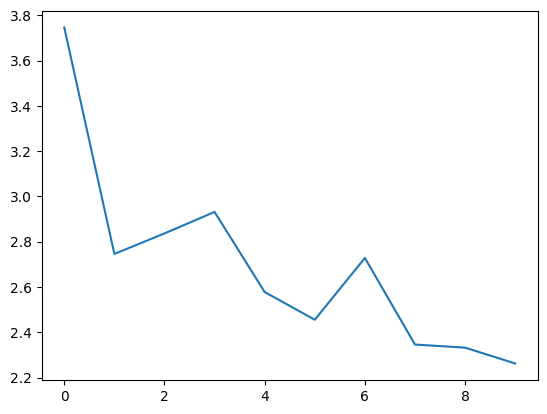

In [26]:
plt.plot(losses)

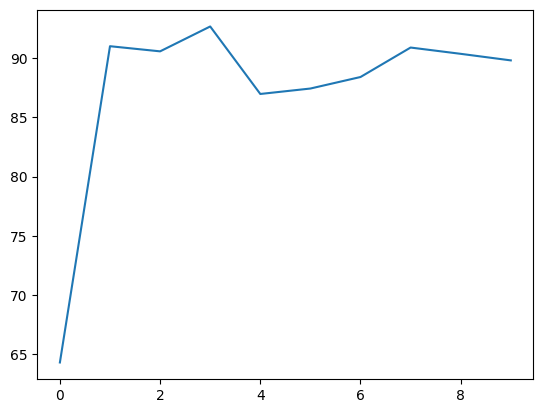

In [27]:
plt.plot(accuracies_per_epoch)


## Conditional Generation

In [24]:
def generate(model, angle, num_iter=100):
    x = gaussian.sample((1,))
    angle = torch.tensor([angle*torch.pi/180])
    for i in np.linspace(0, 1, num_iter, endpoint=False):
        t = torch.tensor([i], dtype=torch.float32)
        sin = torch.sin(angle)
        cos = torch.cos(angle)
        path = model(torch.cat([x, t[:, None], sin[:, None], cos[:, None]], dim=-1))
        x += (0.01 * path)
    return x.detach()

In [28]:
flow = Flow(1024)
flow.load_state_dict(torch.load(model_path))
flow.eval()

def slider(angle):
    x = generate(flow, angle, num_iter=100)[0]
    X, y = get_moons_dataset()
    X_rotated = rotate(X, angle)
    plot_decision_boundary(x, X_rotated, y, title=f"{angle}° degrees")

from ipywidgets import interact
interact(slider, angle=(0, 360, 1))

interactive(children=(IntSlider(value=180, description='angle', max=360), Output()), _dom_classes=('widget-int…

<function __main__.slider(angle)>

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_19032\2270370927.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 89.4053125


<Axes: ylabel='Density'>

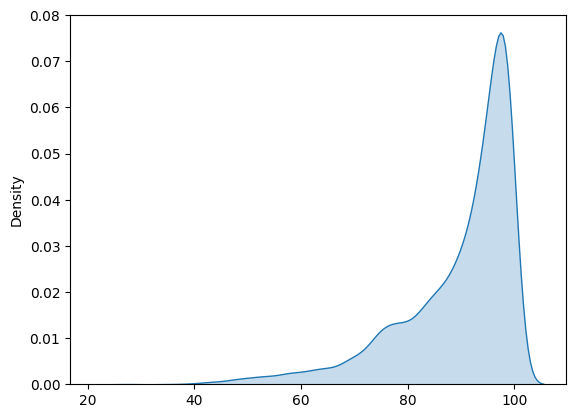

In [29]:
flow = Flow(1024)
flow.load_state_dict(torch.load(model_path))
flow.eval()
flow.to("cpu")

accuracies = []
angles = [0, 45, 90, 135, 180, 225, 270, 315]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(1000):
            x = generate(flow, angle)[0]
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\JetFire\AppData\Local\Temp\ipykernel_19032\2787565138.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


Mean accuracy: 6.537637500000001


<Axes: ylabel='Density'>

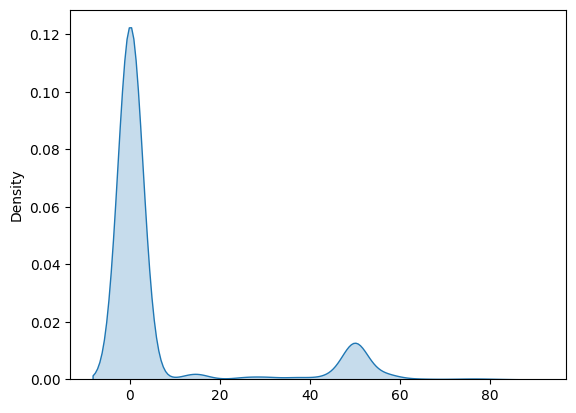

In [31]:
flow = Flow(1024)
flow.load_state_dict(torch.load(model_path))
flow.eval()
flow.to("cpu")

accuracies = []
angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

with torch.no_grad():
    for angle in tqdm(angles):
        for i in range(1000):
            x = generate(flow, angle, 1000)[0]
            x = torch.tensor(x, dtype=torch.float32)

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(x, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))
sns.kdeplot(accuracies, fill=True)

## Parameters distribution

In [29]:
flow = Flow(1024)
flow.load_state_dict(torch.load(model_path))
flow.eval()

angle = 0
accuracies = []

X, y = get_moons_dataset()
X = torch.tensor(X, dtype=torch.float32)

for i in range(1000):
    parameters = generate(flow, angle, num_iter=100)[0]
    accuracy = get_accuracy(parameters, X, y)
    accuracies.append(accuracy)
    
print("Mean accuracy:", np.mean(accuracies))

Mean accuracy: 93.38789999999999


(33, 1000)


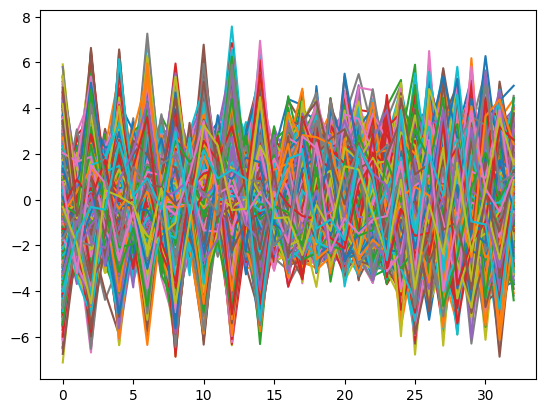

In [19]:
parameters = np.array(parameters)
print(parameters.T.shape)

plt.plot(parameters.T)
plt.show()